In [64]:
import urllib.request
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import sympy as sym
from scipy.special import expit, softmax
from scipy.stats import describe
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

In [65]:
sns.set_theme(palette='tab10')

**Содержание**<a id='toc0_'></a>    
- [__Построение модели логистической регрессии__](#toc1_1_)    
- [__Логистическая функция__](#toc1_2_)    
- [__Нахождение параметров модели__](#toc1_3_)    
- [__Отступ и уверенность классификации__](#toc1_4_)    
- [__Еще раз про logloss__](#toc1_5_)    
- [__Обучение линейного классификатора с помощью градиентного спуска__](#toc1_6_)    
- [__Многоклассовая логистическая регрессия__](#toc1_7_)    
- [__Метрики качества классификации__](#toc1_8_)    
- [__Titanic__](#toc1_9_)    
- [__UCI Spambase__](#toc1_10_)    
- [__Heart Disease Dataset__](#toc1_11_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

***
## <a id='toc1_1_'></a>[__Построение модели логистической регрессии__](#toc0_)

Согласно постановке задачи, каждый объект, обладающий набором предикторов $X_1,X_2,\dots,X_p$, должен быть отнесен к одному из двух классов: к классу $+1$ или, условно, к положительному классу или к классу $-1$ – условно, отрицательному классу:

$$P_+ = P(Y = 1 | X_1,X_2,\dots,X_p),\\
P_- = P(Y = -1 | X_1,X_2,\dots,X_p),\\
P_+ + P_- = 1$$

Перейдем от вероятностей, которые измеряются в диапазоне $[0,1]$, к т.н. шансам.

__Шансом__ отнесения объекта с предикторами $X_1,X_2,\dots,X_p$ к положительному классу называется величина

$$\text{odds}_+ = \text{odds}_+(X_1,X_2,\dots,X_p) = \begin{cases}\frac{P_+}{P_-}, & P_- \ne 0 \\ +\infty, & P_- = 0\end{cases}$$

Преимущество шанса перед вероятностью в том, что шанс принимает любые неотрицательные значения:

$$\text{odds}_+ \in [0,+\infty)$$

Логарифмируя шанс, получим величину, которая может принимать любые значения из [расширенного] множества вещественных чисел:

$$\ln (\text{odds}_+) = \ln \left(\frac{P_+}{1 - P_+}\right) \in (-\infty,+\infty)$$

Мы получили непрерывную переменную, которая зависит от $X_1,X_2,\dots,X_p$ и может принимать любые значения из диапазона $(-\infty,+\infty)$, т.е. задача трансформировалась в задачу регрессии:

$$\ln \left(\frac{P_+}{1 - P_+}\right) = \theta_0 + \theta_1 X_1 + \dots + \theta_p X_p$$

Введем обозначение:

$$\Psi = \Psi(X_1,X_2,\dots,X_p) = \theta_0 + \theta_1 X_1 + \dots + \theta_p X_p$$

Тогда потенцируя $\ln \left(\frac{P_+}{1 - P_+}\right) = \Psi$:

$$e^{\Psi} = \frac{P_+}{1 - P_+}, \\
(1 - P_+) \cdot e^{\Psi} = P_+,$$

$$P_+ = \frac{e^{\Psi}}{1 + e^{\Psi}} = \frac{1}{e^{-\Psi} \cdot (1 + e^{\Psi})} = \frac{1}{1 + e^{-\Psi}} = \frac{1}{1 + e^{-(\theta_0 + \theta_1 X_1 + \dots + \theta_p X_p)}}.$$

***
## <a id='toc1_2_'></a>[__Логистическая функция__](#toc0_)

Функция

$$\Large \sigma(x) = \frac{1}{1 + e^{-x}}$$

называется __логистической функцией__ или __сигмоидой__ и обладает следующими свойствами:

1. $\sigma(x)$ - возрастающая функция;
2. $\sigma(x)$ - непрерывная на $\R$ функция;
3. $\lim_{x \to +\infty} \sigma(x) = 1, \quad \lim_{x \to -\infty} \sigma(x) = 0;$
4. $\sigma(x)$ ограничена двумя горизонтальными асимптотами $y = 0$ и $y = 1$.

[__scipy.special.expit__](https://scipy.github.io/devdocs/reference/generated/scipy.special.expit.html#scipy-special-expit)

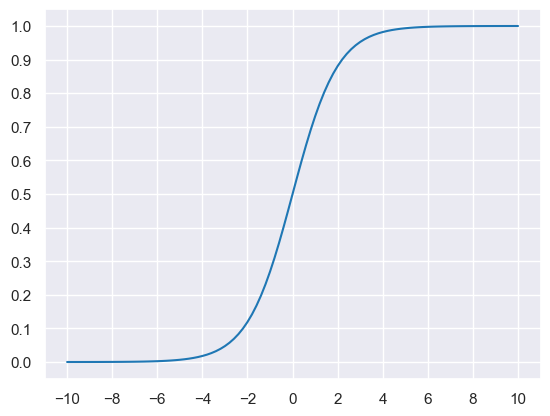

In [66]:
x = np.linspace(-10, 10, 101)
plt.plot(x, expit(x))
plt.xticks(range(-10, 11, 2))
plt.yticks(np.linspace(0, 1, 11))
plt.show()

"Пограничная вероятность" отнесения объекта к классу $+1$ (или $-1$), то есть вероятность $P_+ = P_- = 0.5$, – это значение функции $\sigma(x)$ в точке $0$. В введенных обозначениях это условие равносильно тому, что

$$0 = \Psi = \theta_0 + \theta_1 X_1 + \dots + \theta_p X_p$$

Множество точек, удовлетворяющих данному равенству, – это гиперплоскость (точка на прямой, прямая на плоскости, плоскость в пространстве), лежащая в пространстве $\R^p$ и делящая его на две части. Эти части пространства имеет смысл трактовать следующим образом: в одной из частей лежат точки, для которых $P_+ > 0.5$, то есть точки, которые скорее относятся к положительному, нежели к отрицательному классу, а в другой – точки, для которых $P_+ < 0.5$ (или, что то же самое, $P_- > 0.5$), то есть точки, которые скорее относятся к отрицательному, нежели положительному, классу.

В случае, когда граница двух классов гиперплоскость, классификатор называют __линейным__. Можно сделать вывод, что алгоритм логистической регрессии, по своей сути, является __линейным классификатором__.

Сама по себе логистическая регрессия (функция $P_+$) выдает число в диапазоне $[0,1]$ и часто называется __базовым алгоритмом__. Правило, "отсечка", threshold, согласно которому по выданной вероятности принимается решение об отнесении объекта к тому или иному классу, называется __решающим правилом__. Можно сделать вывод, что алгоритм логистической регрессии это композиция решающего правила и базового алгоритма логистической регрессии.

***
## <a id='toc1_3_'></a>[__Нахождение параметров модели__](#toc0_)

Вероятность отнесения объекта с предикторами $X_1,X_2,\dots,X_p$ к положительному классу $+1$ задается выражением:

$$P_+ = P_+(X_1,X_2,\dots,X_p) = \frac{1}{1 + e^{-\Psi}} = \sigma[\Psi], \quad \sigma(x) = \frac{1}{1 + e^{-x}}.$$

Вероятность отнесения объекта к отрицательному классу $-1$:

$$P_- = 1 - P_+ = 1 - \frac{1}{1 + e^{-\Psi}} = \frac{e^{-\Psi}}{1 + e^{-\Psi}} = \frac{1}{1 + e^{\Psi}} = \sigma[-\Psi].$$

Пусть дан тренировочный набор данных $X = \{x_1,x_2,\dots,x_n\}$ объема $n$,

$$x_i = (x_{i1},x_{i2},\dots,x_{ip}), \quad i \in \{1,2,\dots,n\},$$

причем каждому объекту $x_i$ соответствует отклик $y_i \in Y = \{-1,1\}$.

Введем обозначение

$$M(\theta, x_i) = y_i(\theta_0 + \theta_1 x_{i1} + \theta_2 x_{i2} + \dots + \theta_p x_{ip})$$

Если объект тренировочных данных относится к классу $+1$, то, поскольку $y_i = 1$,

$$\sigma[M(\theta, x_i)] = \frac{1}{1 + e^{-(\theta_0 + \theta_1 x_{i1} + \theta_2 x_{i2} + \dots + \theta_p x_{ip})}} = P_+,$$

а если к классу $-1$, то, поскольку $y_i = -1$, 

$$\sigma[M(\theta, x_i)] = \frac{1}{1 + e^{(\theta_0 + \theta_1 x_{i1} + \theta_2 x_{i2} + \dots + \theta_p x_{ip})}} = P_-.$$

Естественно, имея тренировочный набор данных, в откликах которого мы
уверены, все получившиеся вероятности должны быть настолько близкими
к единице, насколько это возможно. "Настраивать" указанную близость мы
можем, меняя значения $\theta_0,\theta_1,\dots,\theta_p$. Ясно, что для этого логично использовать метод максимального правдоподобия. Тогда функция правдоподобия:

$$f(X,\theta) = \sigma[M(\theta,x_1)] \cdot \sigma[M(\theta,x_2)] \cdot ... \cdot \sigma[M(\theta,x_n)] = \prod_{i=1}^n \sigma[M(\theta,x_i)].$$

Логарифмическая функция правдоподобия:

$$L(X,\theta) = \sum_{i=1}^n \ln \left(\sigma[M(\theta,x_i)]\right)$$

Задача максимизации логарифмической функции правдоподобия

$$\argmax_{\theta} \sum_{i=1}^n \ln \left(\sigma[M(\theta,x_i)]\right) =$$

$$=\argmax_{\theta} \sum_{i=1}^n \ln \left(1 + e^{-M(\theta,x_i)}\right)^{-1} = \argmin_{\theta} \sum_{i=1}^n \ln \left(1 + e^{-M(\theta,x_i)}\right)$$

эквивалентна минимизации функции

$$\text{logloss}(X,\theta) = \sum_{i=1}^n \ln \left(1 + e^{-M(\theta,x_i)}\right),$$

которая называется __логистической функцией ошибки (логистической функцией потерь)__.

$$\text{logloss}(X,\theta) =\sum_{i=1}^n \begin{cases} \ln \left(1 + e^{-\Psi}\right) = -\ln\left(\frac{1}{1 + e^{-\Psi}}\right) = -\ln(\sigma[\Psi]), & y_i = 1 \\ \ln \left(1 + e^{\Psi}\right) = -\ln\left(\frac{1}{1 + e^{\Psi}}\right) = -\ln(\sigma[-\Psi]) = -\ln(1 - \sigma[\Psi]), & y_i = -1\end{cases}.$$

***
## <a id='toc1_4_'></a>[__Отступ и уверенность классификации__](#toc0_)

Величина

$$M(\theta,x_i) = y_i(\theta_0 + \theta_1 x_{i1} + \dots + \theta_p x_{ip})$$

называется __отступом (margin)__ объекта $x_i$.

Отступ показывает "степень погруженности" объекта в класс: чем больше отступ, тем дальше находится объект от разделяющей гиперплоскости $\theta_0 + \theta_1 X_1 + \dots + \theta_p X_p = 0$ и тем увереннее его классификация, и наоборот.  Отступ $M(\theta,x_i)$ отрицателен тогда и только тогда, когда объект неправильно классифицирован алгоритмом.

***
## <a id='toc1_5_'></a>[__Еще раз про logloss__](#toc0_)

__Пусть теперь имеем задачу классификации с классами $0$ и $1$.__ Обучающую выборку можно рассматривать как реализацию обобщенной схемы Бернулли: для каждого объекта генерируется случайная величина, которая с вероятностью $p$ (своей для каждого объекта) принимает значение $1$ и с вероятностью $(1–p)$ – значение $0$. Предположим, что мы как раз и строим нашу модель так, чтобы она генерировала правильные вероятности, но тогда можно записать функцию правдоподобия:

$$p(y | X, w) = \prod_i p(y_i | x_i, w) = \prod_i a^{y_i}_i (1 - a_i)^{1 - y_i} \to \max,$$

где $a_i = a(x_i | w)$ - ответ алгоритма, зависящего от параметров $w$, на $i$-ом объекте.

После логарифмирования правдоподобия получим, что его максимизация эквивалентна минимизации выражения

$$\sum_i \biggl(-y_i \log a_i - (1 - y_i) \log (1 - a_i)\biggr) \to \min$$

Именно его и называют __логистической функцией ошибки__. Для задачи бинарной классификации, в которой алгоритм должен выдать вероятность принадлежности классу $1$, она логична ровно настолько, насколько логична MSE в задаче линейной регрессии с нормальным шумом, поскольку обе функции ошибки выводятся из метода максимального правдоподобия.

In [67]:
a, y, z = sym.symbols('a y z')
L = -y*sym.log(a) - (1 - y)*sym.log(1 - a)
sym.diff(L, a).simplify()

(-a + y)/(a*(a - 1))

In [68]:
sym.diff(1 / (1 + sym.exp(-z)), z)

exp(-z)/(1 + exp(-z))**2

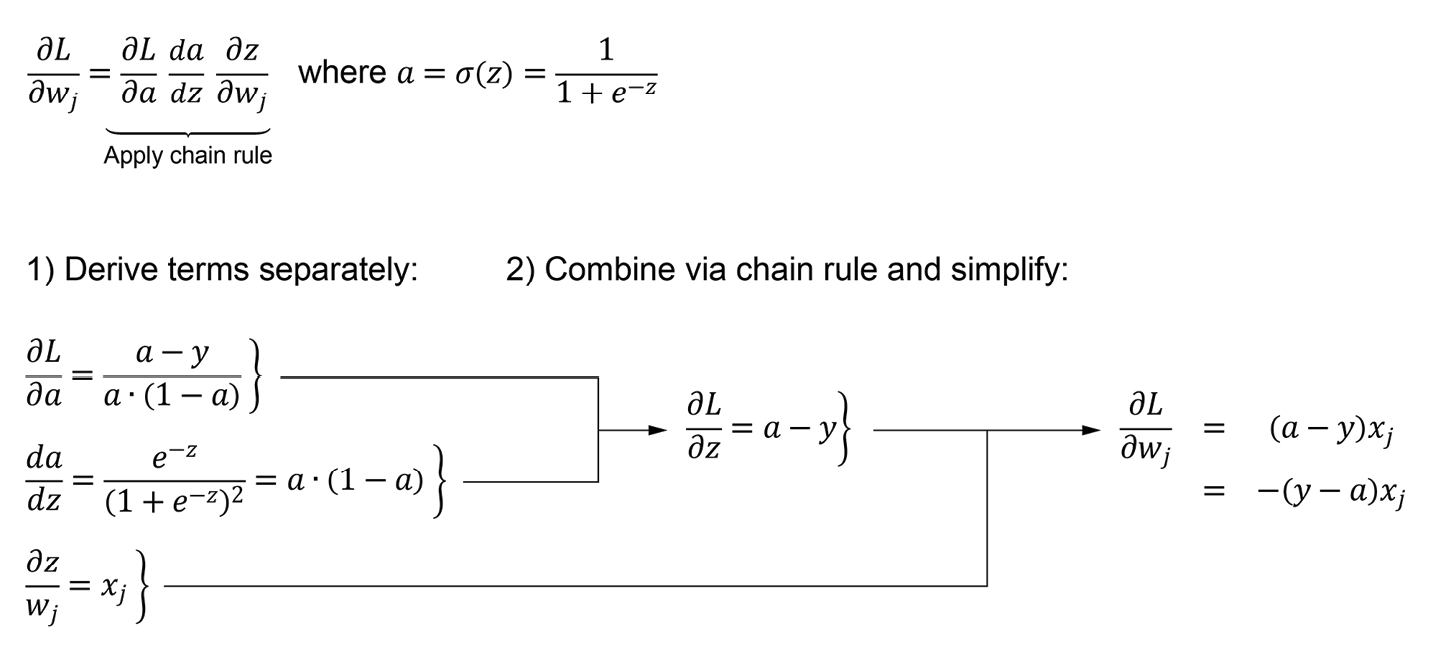

Как видим, корректировка весов точно такая же, как и при настройке линейной регрессии! 

$$w := w - \eta \cdot (a - y)x$$

На самом деле, это говорит о родстве разных регрессий: линейной и логистической, а точнее, о родстве распределений: нормального и Бернулли.

Часто гораздо более понятна такая запись logloss-ошибки на одном объекте:

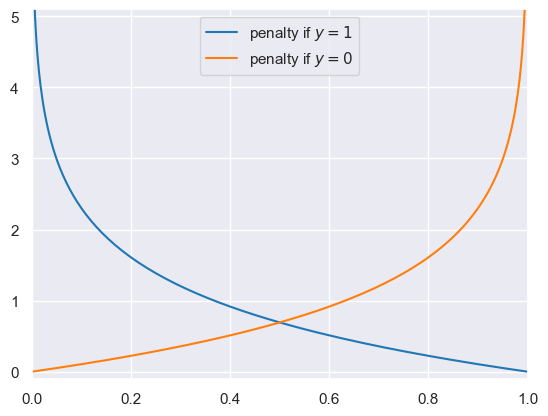

In [69]:
x = expit(np.arange(-10, 10, 0.1))
plt.plot(x, -np.log(x), label='penalty if $y = 1$')
plt.plot(x, -np.log(1 - x), label='penalty if $y = 0$')
plt.xlim(0,1)
plt.ylim(-0.1,5.1)
plt.legend(loc='upper center')
plt.show()

We can see that the loss approaches $0$ if we correctly predict that an example belongs to class $1$. Similarly, we can see on the $y$ axis that the loss also approaches $0$ if we correctly predict
$y = 0$. However, if the prediction is wrong, the loss goes toward infinity. The main point is that we penalize wrong predictions with an increasingly larger loss.

...Таким образом, грубая ошибка на одном объекте сразу делает алгоритм бесполезным. На практике часто logloss ограничивают ([__numpy.clip__](https://numpy.org/doc/stable/reference/generated/numpy.clip.html#numpy-clip)) каким-то большим числом, чтобы не связываться с бесконечностями.

***
## <a id='toc1_6_'></a>[__Обучение линейного классификатора с помощью градиентного спуска__](#toc0_)

Особенность линейных классификаторов заключается в том, что решение о принадлежности объекта к какому-либо классу принимается на основе **линейной комбинации** его характеристик (значений признаков). Пусть в датасете $d$ признаков. Тогда ответ линейного классификатора:

$$
y = f\left(\sum\limits_{j = 1}^d w_jx_j\right), \qquad\qquad (1)
$$

где $f$ - какая-то функция, подходящая по смыслу задаче (выдающая конечное множество значений - классов), а $w_j$ - веса классификатора. Понятно, что так как мы можем выбрать любую разумную $f$, можно "сдвинуть" параметр функции $f$ на некоторое число $w_0$. Тогда формулу $(1)$ можно переписать как

$$
y = f\left(w_0 + \sum\limits_{j = 1}^d w_jx_j\right) \qquad\qquad (2)
$$

В задаче бинарной классификации $f$ может быть функцией, которая выдает разные ответы в зависимости от того, какой знак, плюс или минус, имеет рассматриваемое значение:

$$
y = \operatorname{sign}\left(w_0 + \sum\limits_{j = 1}^d w_jx_j\right) = \begin{cases} 1, & w_0 + \sum\limits_{j = 1}^d w_jx_j \geq 0 \\ -1, & w_0 + \sum\limits_{j = 1}^d w_jx_j < 0 \end{cases} \qquad\qquad (3)
$$

Если в качестве $f$ выбрать сигмоидную функцию, то получится логистическая регрессия, где на выходе получается вероятность положительного класса:

$$
y = \sigma\left(w_0 + \sum\limits_{j = 1}^d w_jx_j\right) = \frac{1}{1 + \exp\left(-w_0 - \sum\limits_{j = 1}^d w_jx_j\right)}
$$

Приравняем рассматриваемое "сдвинутое" значение линейной комбинации к нулю:

$$
w_0 + \sum\limits_{j = 1}^d w_jx_j = 0 \qquad\qquad (4)
$$

Это уравнение прямой на плоскости, в котором есть переменные ($x_1$ и $x_2$), веса ($a$ и $b$) и свободный коэффициент ($c$):

$$
ax_1 + bx_2 + c = 0
$$

Формула $(4)$ - это уравнение **гиперплоскости**, обобщение прямой на плоскости на пространства любых размерностей. Если говорить строго, прямая является подпространством размерности $1$ пространства размерности $2$ (плоскости), то есть ее размерность на $1$ меньше, чем у исходного пространства. А гиперплоскость - подпространство размерности $(d - 1)$ пространства размерности $d$.

Уравнение $(3)$ показывает, **по какую сторону от гиперплоскости лежит объект**. Если объект лежит по одну сторону от гиперплоскости, то он относится к положительному классу, если по другую - к отрицательному. Классификатор строит **разделяющую гиперплоскость**, деляющую пространство на две области - один класс и другой.

Для наглядности разберем случай $d = 2$ на примере синтетических данных. Уравнение разделяющей гиперплоскости (прямой:

$$
w_0 + w_1x_1 + w_2x_2 = 0
$$

Зададим веса $w_0 = w_1 = w_2 = 1$ и посмотрим на прямую:

In [128]:
"""есть люди типа жив и люди типа помер,
но нет никого, кто знал бы твой номер"""
random_state = 2128506

In [129]:
X, y = make_blobs(n_samples=1000, n_features=2, centers=2, 
                  cluster_std=3, random_state=random_state)
mask = y == 0
y[mask] = -1
y.sum()  # 500/500

0

In [130]:
w_init = np.ones((3,))
x = np.linspace(*describe(X[:,0]).minmax)

In [131]:
def plotHPlanes(weights_vectors):
    for w in weights_vectors:
        plt.plot(x, -(w[1]*x + w[0]) / w[2])

In [132]:
def plotClf(*weights_vectors):
    plt.figure(figsize=(8,8))
    plt.scatter(*X.T, c=np.where(mask, 'blue', 'red'), s=10)
    plotHPlanes(weights_vectors)

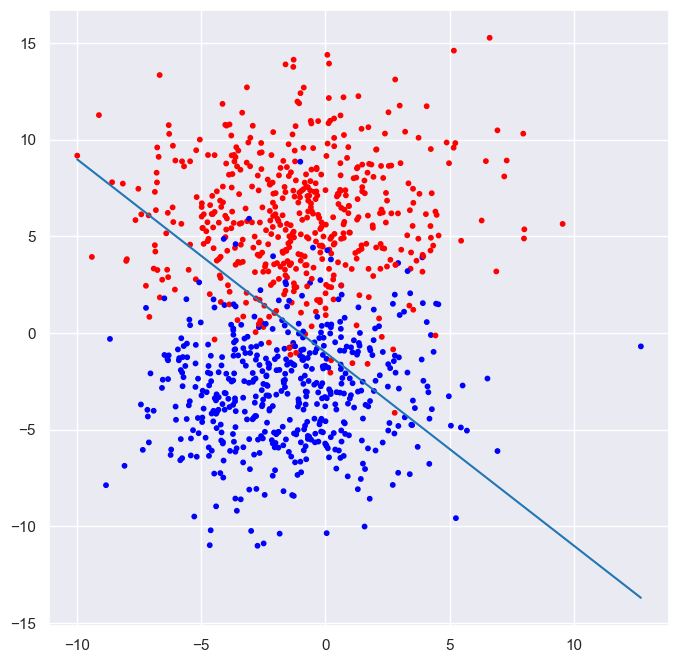

In [133]:
plotClf(w_init)

Оптимальное разбиение будем искать с помощью градиентного спуска и логистической функции потерь:

$$
\tilde{Q}(w, X) = \frac{1}{\ell}\sum\limits_{i=1}^\ell\log\left(1 + \exp(-y_i\langle w, x_i\rangle)\right) \rightarrow \min_w
$$

Здесь $\ell$ - количество объектов в данных ($500$ в примере), $w$ - вектор весов, $x_i$ - признаковое описание $i$-ого объекта. Для удобства мы предполагаем, что в данных уже есть единичный признак, соответствующий весу $w_0$, поэтому уравнение $(4)$ превращается в скалярное произведение:

$$
\langle w, x\rangle = 0
$$

Градиент выбранной функции потерь:

$$
\nabla_w\tilde{Q}(w, X) = -\frac{1}{\ell}\sum\limits_{i=1}^\ell\frac{y_ix_i}{1 + \exp(y_i\langle w, x_i\rangle)}
$$

Формула градиентного спуска:

$$
w^{(t)} = w^{(t - 1)} - \eta\nabla_w\tilde{Q}(w, X)
$$

Реализуем формулы функции потерь и ее градиента, а также добавим в данные единичный признак.

In [134]:
def logLoss(w, X, y):
    return np.log(1 + np.exp(-y * (X @ w))).mean()

In [135]:
def loglossGrad(w, X, y):
    numer = X * y.reshape(-1,1)  # (1000, 3)
    denom = (1 + np.exp(y * (X @ w))).reshape(-1,1)  # (1000,) -> (1000, 1)
    return -(numer / denom).mean(axis=0)

In [136]:
def gradDescent(X, y, w, nsteps, lrate):
    loss_array = [logLoss(w, X, y)]
    for _ in range(nsteps):
        w -= lrate * loglossGrad(w, X, y)
        loss_array.append(logLoss(w, X, y))
    return w, loss_array

In [137]:
w_manual, loss_array = gradDescent(sm.add_constant(X), y, w_init.copy(),
                                   nsteps=1000, lrate=0.1)

График падения значения функции потерь в зависимости от номера шага градиентного спуска:

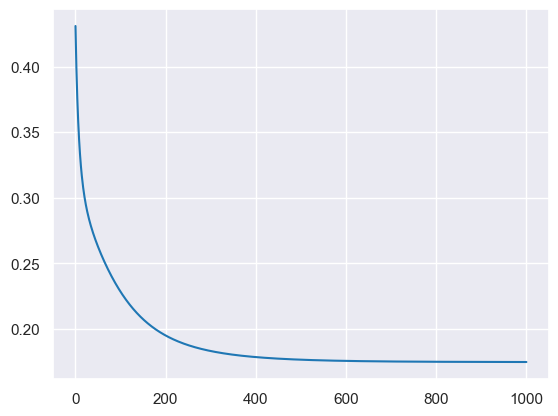

In [138]:
plt.plot(loss_array)

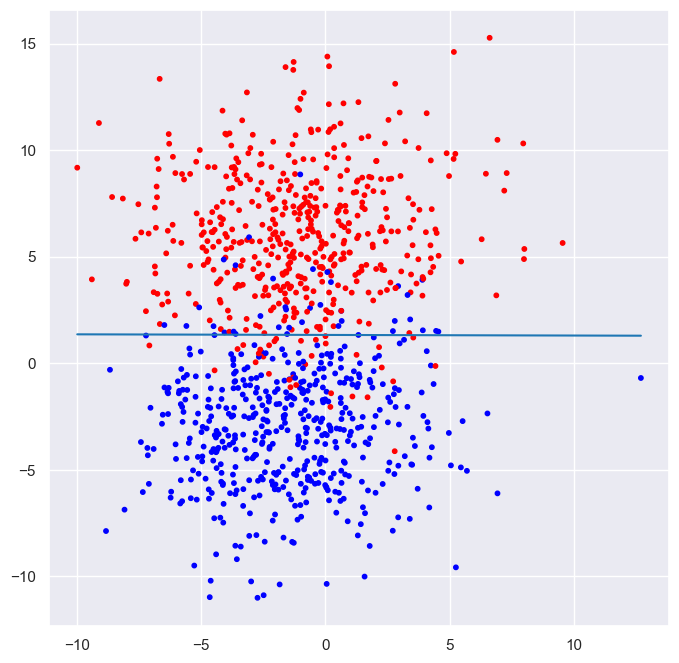

In [139]:
plotClf(w_manual)

In [140]:
clf = SGDClassifier(
    loss='log_loss', random_state=random_state, 
    learning_rate='constant', eta0=0.1
)
clf.fit(X, y)  # SGDClassifier сам добавляет константный признак

SGDClassifier(eta0=0.1, learning_rate='constant', loss='log_loss',
              random_state=2128506)

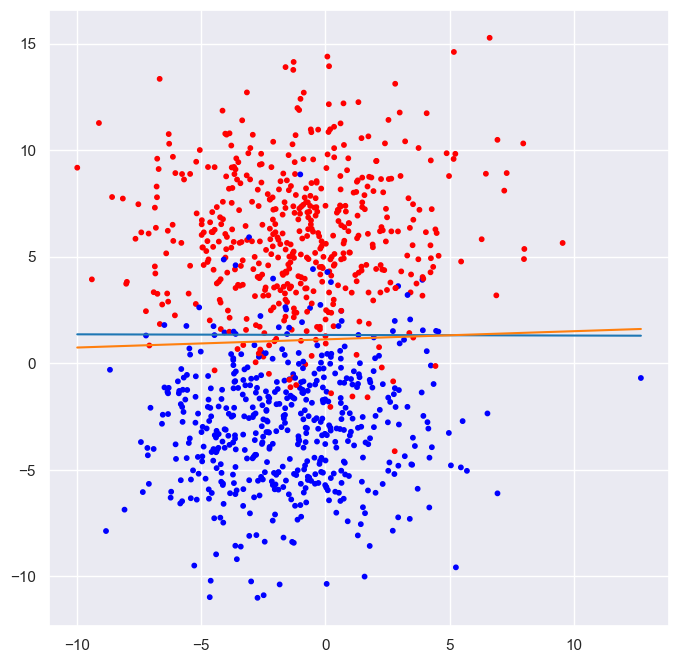

In [141]:
w_clf = np.insert(clf.coef_[0], 0, clf.intercept_.item())
plotClf(w_manual, w_clf)

***
## <a id='toc1_7_'></a>[__Многоклассовая логистическая регрессия__](#toc0_)

Пусть каждый объект, имеющий набор предикторов $X_1,X_2,\dots,X_p$, должен быть отнесен к одному из $M$ классов из $Y = \{1,2,\dots,M\}$.

$$P_k = P(Y = k|X_1,X_2,\dots,X_p) = \frac{e^{\Psi_k}}{1 + \sum_{i=1}^{M-1} e^{\Psi_i}}, \quad k \in \{1,2,\dots,M-1\},$$

$$P_M = P(Y = M|X_1,X_2,\dots,X_p) = \frac{1}{1 + \sum_{i=1}^{M-1} e^{\Psi_i}},$$

$$\Psi_i = \Psi(X_1,X_2,\dots,X_p) = \theta_0^i + \theta_1^i X_1 + \dots + \theta_p^i X_p, \quad i \in \{1,2,\dots,M-1\}.$$

In [142]:
X = np.array([[10, 1], [7, 4], [8, 3], [2, 2], [1, 5],
              [3, 3], [2, 1], [3, 2], [2, 8], [9, 8],
              [4, 10], [2, 9], [3, 7], [8, 7]])

y = np.array([1, 1, 1, 2, 2, 2, 2, 2, 3, 1, 3, 3, 3, 1])

In [143]:
colors = {1: "purple", 2: "white", 3: "black"}
f = lambda label: colors[label]
x = np.linspace(0, 11, 12)
tested = np.array([[6, 9]])

$w_1 x_1 + w_2 x_2 + b = 0, \quad x_2 = \frac{w_1 x_1 + b}{-w_2}$

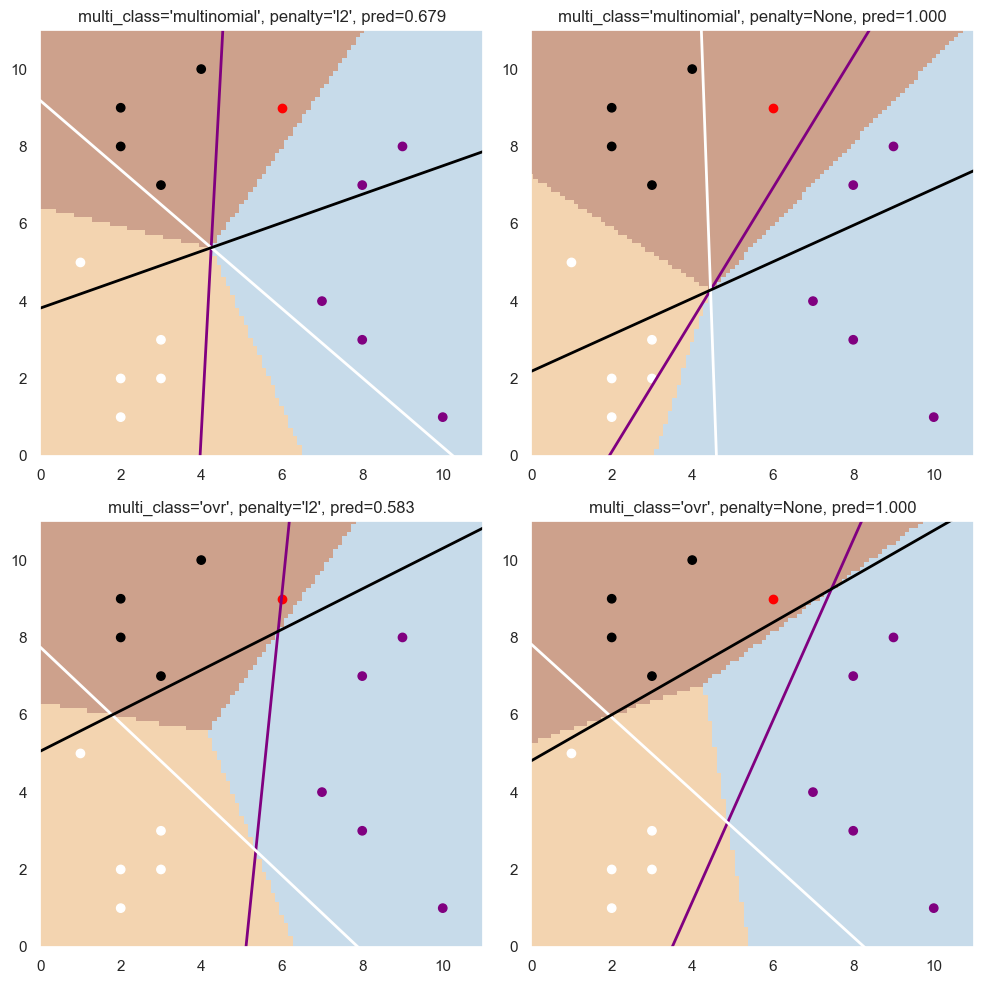

In [144]:
axs = plt.subplots(2, 2, figsize=(10,10))[1]
it = axs.flat

for multi_class, penalty in product(['multinomial', 'ovr'], ['l2', None]):
    clf = LogisticRegression(
        multi_class=multi_class, penalty=penalty
    )
    clf.fit(X, y)    
    pred = clf.predict_proba(tested).max()
    ax = next(it)
    
    for i in range(3):
        (w1, w2), bias = clf.coef_[i], clf.intercept_[i]
        ax.plot(x, -(w1*x + bias) / w2, lw=2, c=colors[i+1])
        
    DecisionBoundaryDisplay.from_estimator(
        clf, X,
        cmap=plt.cm.Paired, ax=ax,
        response_method='predict',
        plot_method='pcolormesh',
        shading='auto', alpha=0.5,
        eps=1
    )

    ax.scatter(*X.T, c=np.vectorize(f)(y))
    ax.scatter(*tested[0], c='r')
    
    ax.set_xlim(0,11)
    ax.set_ylim(0,11)
    ax.set_title(f'{multi_class=}, {penalty=}, {pred=:.3f}')
    
plt.tight_layout()

[__sklearn.linear_model.LogisticRegression__](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn-linear-model-logisticregression) | [__Logistic regression__](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

Обрати внимание:

In [145]:
clf = LogisticRegression(multi_class='multinomial').fit(X, y)
np.all(softmax(tested @ clf.coef_.T + clf.intercept_) == clf.predict_proba(tested))

True

[__scipy.special.softmax__](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.softmax.html#scipy-special-softmax)

***
## <a id='toc1_8_'></a>[__Метрики качества классификации__](#toc0_)

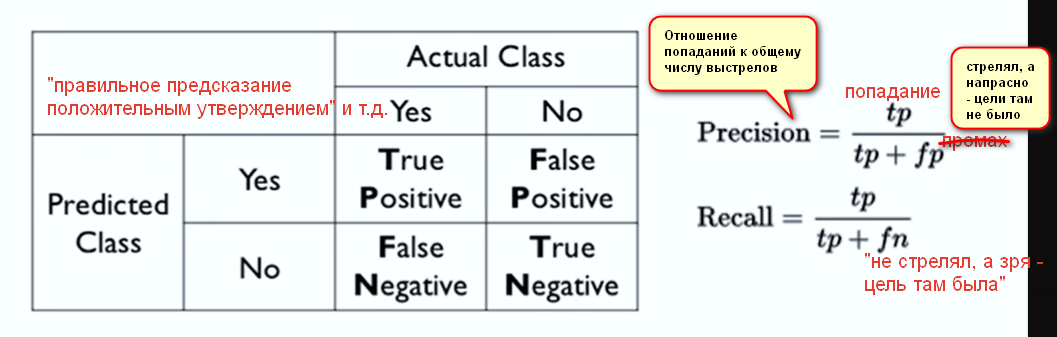
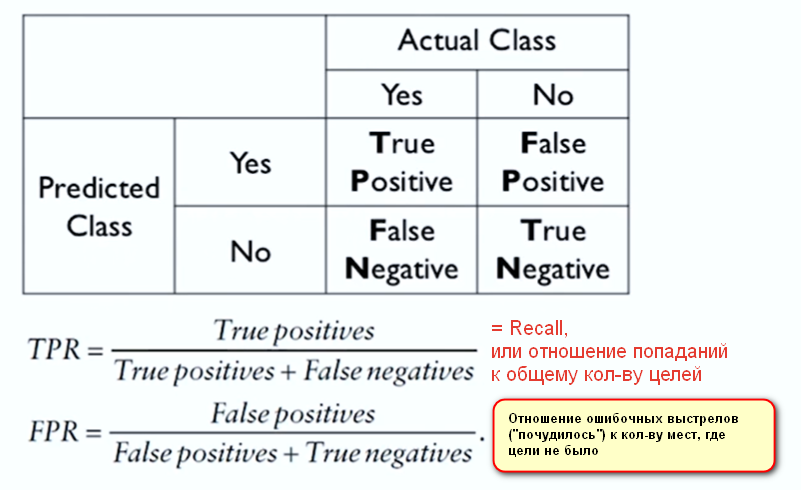

__Матрица ошибок (confusion matrix)__ – способ разделить объекты на $4$ группы в зависимости от комбинации истинного класса и ответа классификатора (_исходно_ понимать как _в действительности_):
* $TP\;(\text{True Positives})$ - верно классифицированные объекты, исходно относящиеся к классу $+1$;
* $TN\;(\text{True Negatives})$ - верно классифицированные объекты, исходно относящиеся к классу $-1$;
* $FP\;(\text{False Positives})$ - неверно классифицированные объекты, исходно относящиеся к классу $-1$ (__ошибка I рода__: ситуация "перебздели"; эффект обнаружен тогда, когда его на самом деле нет; объект распознан как цель, "чужой", хотя на самом деле "свой");
* $FN\;(\text{False Negatives})$ - неверно классифицированные объекты, исходно относящиеся к классу $+1$ (__ошибка II рода__: ситуация "прошляпили"; решили, что эффекта нет, хотя на самом деле он есть; приняли объект за "свой", хотя на самом деле это "цель").

__Accuracy (точность)__ - доля правильных ответов классификатора:
$$\text{Accuracy} = \frac{TP + TN}{TP + FP + FN + TN}.$$

Эта величина показывает отношение количества верно классифицированных объектов к общему количеству классифицируемых объектов и, грубо говоря, оценивает вероятность случайному объекту быть правильно классифицированным.

Доля истинноположительных примеров – __True Positives Rate (TPR)__ или __Sensitivity (чувствительность)__ или __Recall__:

$$\text{TPR} = \text{Recall} = \frac{TP}{TP + FN}$$

_Отношение количества попаданий к общему количеству целей_. Эта величина показывает отношение количества верно классифицированных объектов, относящихся к классу $+1$, к общему количеству объектов класса $+1$. Иными словами, это оценка вероятности, что объект, относящийся к классу $+1$ будет классифицирован корректно.

Доля ложноположительных примеров __False Positives Rate (FPR)__:

$$\text{FPR} = \frac{FP}{FP + TN}$$

_Отношение количества ошибочных выстрелов ("почудилось") к количеству случаев, мест, где цели не было_. Величина показывает отношение количества неверно классифицированных объектов, относящихся к классу $-1$, к общему количеству объектов класса $-1$, или оценивает вероятность, что объект, относящийся к классу $-1$, будет классифицирован неверно.

__Специфичность (Specificity)__ или __True Negatives Rate (TNR)__:

$$\text{TNR} = 1 - \text{FPR} = \frac{TN}{TN + FP}$$

Величина показывает отношение количества верно классифицированных объектов, относящихся к классу $-1$, к общему количеству объектов класса $-1$, или оценивает вероятность, что объект, относящийся к классу $-1$, будет классифицирован верно.

__Precision (точность)__:

$$\text{Precision} = \frac{TP}{TP + FP}$$

Величина показывает, какая доля объектов, отнесенных классификатором классу $+1$, действительно относится к этому классу.

Пусть к положительному классу относятся пациенты, имеющие заболевание, а к отрицательному – не имеющие. __Чувствительный диагностический тест__ (с высоким $\text{TPR}$) – это тот, который правильно идентифицирует пациентов с заболеванием. То есть если тест на $100\%$ чувствителен ($\text{TPR} = 1$), то он верно определит всех пациентов, у которых есть заболевание (то есть всем болеющим скажет, что они больны). В то же время, он может записать к заболевшим и тех, кто не болен. Высокочувствительный тест полезен для исключения заболевания.

__Специфичный диагностический тест__ (с высоким $\text{TNR}$) диагностирует только доподлинно больных, то есть если тест имеет $100\%$ специфичность ($\text{TNR} = 1$), он будет верно идентифицировать пациентов, которые не имеют заболевания, но может записать к здоровым и больных. Такой тест важен при лечении пациентов с определенным заболеванием.

__F-мера__ ($F_1$-мера, $F$ score, $F_1$ score):

$$F = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}.$$

$F$-мера  является  средним  гармоническим величин $\text{Precision}$ и $\text{Recall}$ и заключена в диапазоне $[0,1]$. Среднее гармоническое обладает важным свойством: оно близко к нулю, если хотя бы один из аргументов близок к нулю. Поэтому оно является более предпочтительным, чем, скажем, среднее арифметическое: если алгоритм относит все объекты к положительному классу, то $\text{Recall} = 1$, а $\text{Precision}$, скорее всего, будет небольшим. Но тогда среднее арифметическое будет больше, чем $0.5$, что не годится.

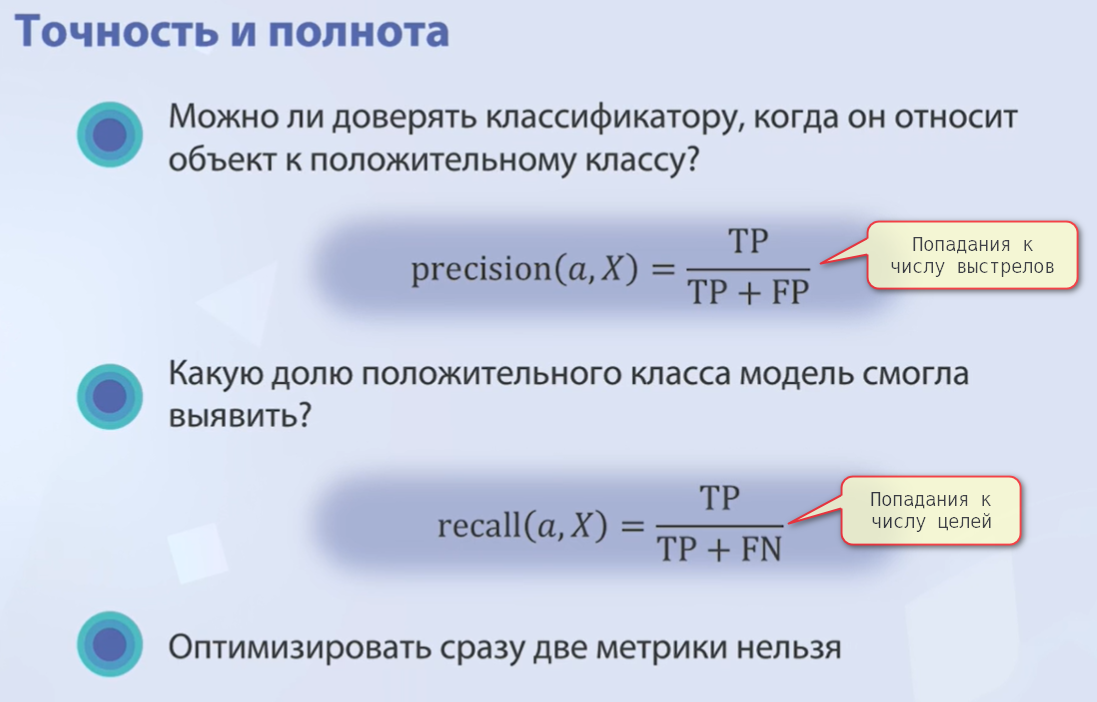

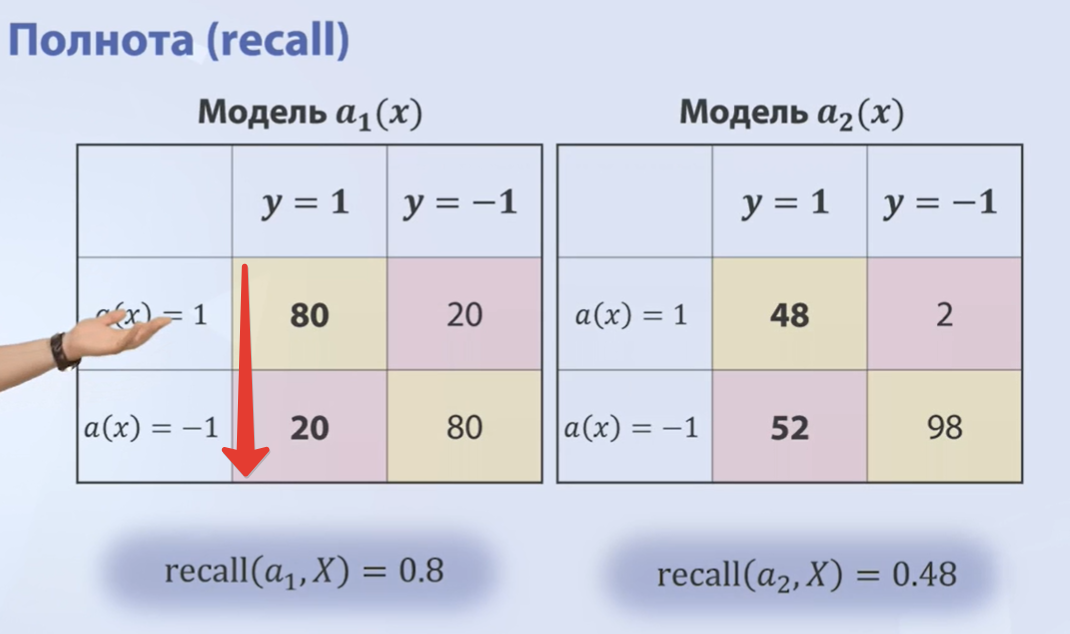

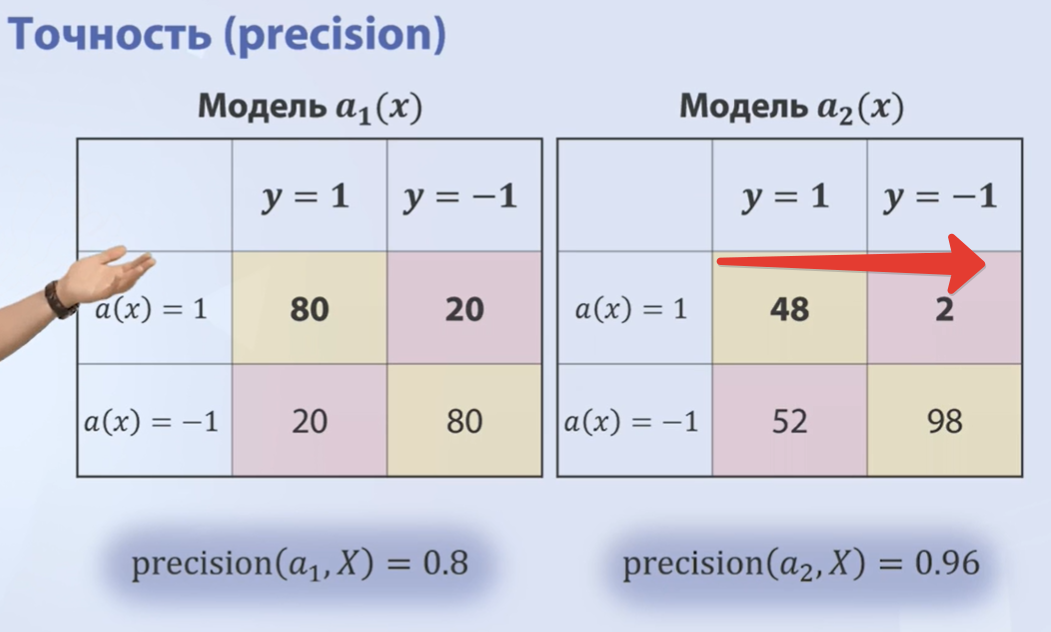

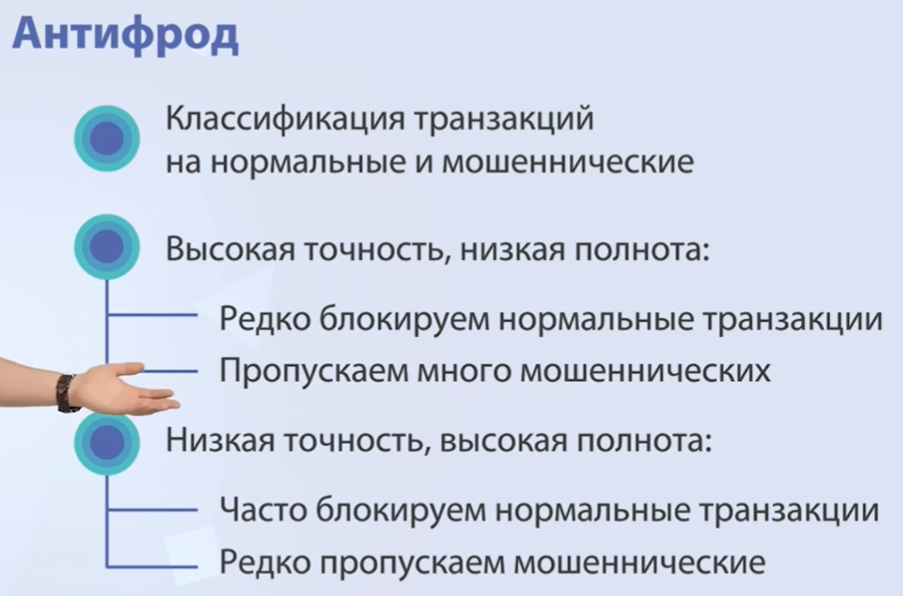

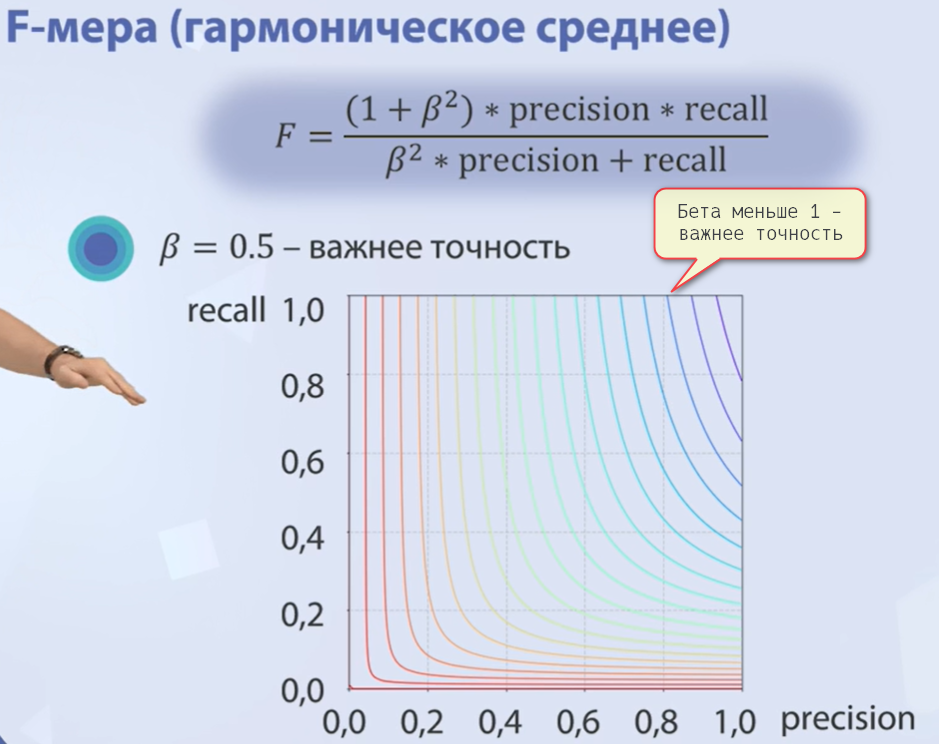

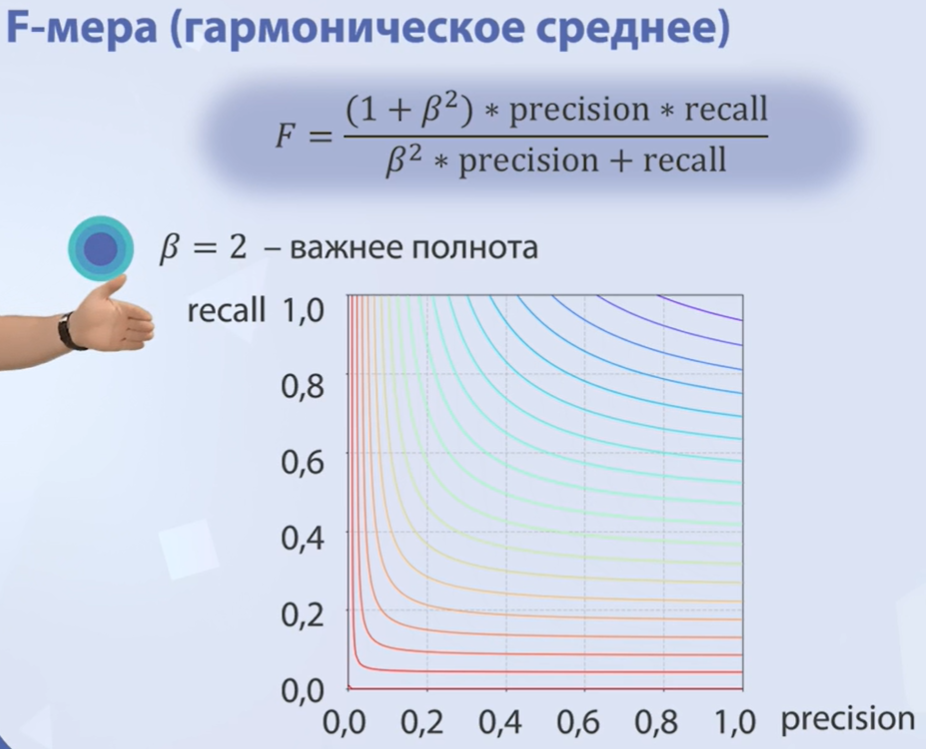

In [146]:
data = np.array([[5, 60, 10, 1], [1, 35, 3, 1], [3, 45, 6, 0],
                 [1, 53, 10, 0], [7, 70, 11, 1], [3, 65, 12, 1],
                 [1, 30, 2, 1], [2, 40, 9, 0], [10, 71, 15, 1],
                 [6, 54, 12, 1], [7, 65, 15, 0], [0, 30, 3, 0]])

headers = 'Hits on target', 'Possession', 'Hits', 'Result_true'
df = pd.DataFrame(data, columns=headers)
df

,Hits on target,Possession,Hits,Result_true
0,5,60,10,1
1,1,35,3,1
2,3,45,6,0
3,1,53,10,0
4,7,70,11,1
5,3,65,12,1
6,1,30,2,1
7,2,40,9,0
8,10,71,15,1
9,6,54,12,1


In [147]:
thetas = np.array([-0.046, 0.541, -0.014, -0.132])
f = lambda row: expit(row[:-1] @ thetas)
P = np.apply_along_axis(f, axis=1, arr=sm.add_constant(data))
P

array([0.6222243 , 0.40347659, 0.53867261, 0.17264449, 0.78734577,
       0.28556956, 0.45289015, 0.32915706, 0.91606157, 0.70266065,
       0.70077687, 0.29692166])

In [148]:
df['Result_pred'] = np.where(P >= 0.5, 1, 0)
df[['Result_true', 'Result_pred']]

,Result_true,Result_pred
0,1,1
1,1,0
2,0,1
3,0,0
4,1,1
5,1,0
6,1,0
7,0,0
8,1,1
9,1,1


In [149]:
d = {1: 'p', 0: 'n'}
conf = {}  # confusion matrix contents

for label, name in d.items():
    subframe = df[df.Result_pred == label]
    matches = np.equal(subframe.Result_pred, subframe.Result_true).sum()
    conf[f't{name}'] = matches
    conf[f'f{name}'] = subframe.shape[0] - matches
    
conf

{'tp': 4, 'fp': 2, 'tn': 3, 'fn': 3}

In [150]:
recall = tpr = conf['tp'] / (conf['tp'] + conf['fn'])
recall

0.5714285714285714

In [151]:
precision = conf['tp'] / (conf['tp'] + conf['fp'])
precision

0.6666666666666666

In [152]:
fscore = 2 * precision * recall / (precision + recall)
fscore

0.6153846153846153

In [153]:
recall == metrics.recall_score(df.Result_true, df.Result_pred)

True

In [154]:
precision == metrics.precision_score(df.Result_true, df.Result_pred)

True

In [155]:
fscore == metrics.f1_score(df.Result_true, df.Result_pred)

True

[__sklearn.metrics.roc_curve__](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn-metrics-roc-curve)

In [156]:
fpr, tpr, thresholds = metrics.roc_curve(
    df.Result_true, P,
    drop_intermediate=False
)

In [157]:
fpr

array([0. , 0. , 0. , 0. , 0.2, 0.2, 0.4, 0.4, 0.4, 0.6, 0.8, 0.8, 1. ])

In [158]:
tpr

array([0.        , 0.14285714, 0.28571429, 0.42857143, 0.42857143,
       0.57142857, 0.57142857, 0.71428571, 0.85714286, 0.85714286,
       0.85714286, 1.        , 1.        ])

In [159]:
thresholds

array([1.91606157, 0.91606157, 0.78734577, 0.70266065, 0.70077687,
       0.6222243 , 0.53867261, 0.45289015, 0.40347659, 0.32915706,
       0.29692166, 0.28556956, 0.17264449])

In [160]:
np.flip(np.sort(P))

array([0.91606157, 0.78734577, 0.70266065, 0.70077687, 0.6222243 ,
       0.53867261, 0.45289015, 0.40347659, 0.32915706, 0.29692166,
       0.28556956, 0.17264449])

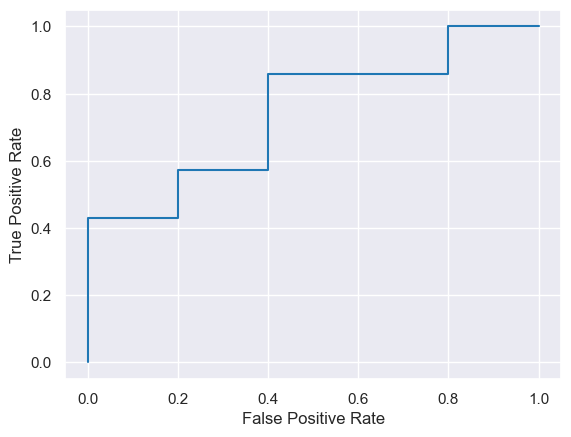

In [161]:
metrics.RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [162]:
metrics.roc_auc_score(df.Result_true, P)

0.7428571428571428

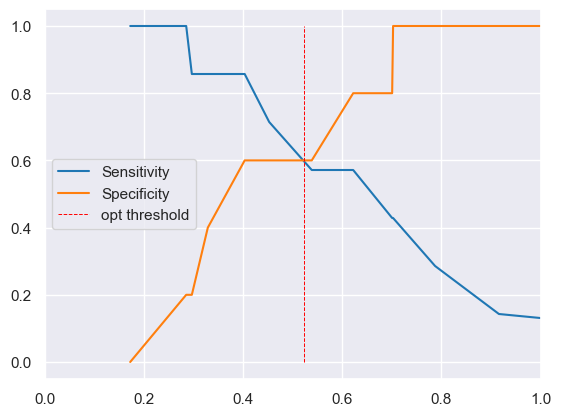

In [163]:
plt.plot(thresholds, tpr, label='Sensitivity')
plt.plot(thresholds, 1 - fpr, label='Specificity')
plt.vlines(0.5225, 0, 1, ls='--', lw=0.7, 
           color='r', label='opt threshold')
plt.xlim(0,1)
plt.legend()
plt.show()

***
## <a id='toc1_9_'></a>[__Titanic__](#toc0_)

[__Dataset description__](https://www.kaggle.com/competitions/titanic/data)

In [164]:
data = pd.read_csv('titanic/train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [165]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [166]:
predictors = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X = data[predictors]
y = data.Survived

In [167]:
X.isnull().sum()

Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [168]:
X = X.fillna({'Age': X.Age.mean(), 'Embarked': 'NA'})
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       891 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  891 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 48.9+ KB


In [169]:
X.Sex.unique()

array(['male', 'female'], dtype=object)

In [170]:
X.Sex = X.Sex.map({'male': 1, 'female': 0})

In [171]:
X.Embarked.unique()

array(['S', 'C', 'Q', 'NA'], dtype=object)

In [172]:
X = pd.get_dummies(X, columns=['Embarked'])
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pclass       891 non-null    int64  
 1   Sex          891 non-null    int64  
 2   Age          891 non-null    float64
 3   SibSp        891 non-null    int64  
 4   Parch        891 non-null    int64  
 5   Fare         891 non-null    float64
 6   Embarked_C   891 non-null    uint8  
 7   Embarked_NA  891 non-null    uint8  
 8   Embarked_Q   891 non-null    uint8  
 9   Embarked_S   891 non-null    uint8  
dtypes: float64(2), int64(4), uint8(4)
memory usage: 45.4 KB


In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train, X_test = scale(X_train), scale(X_test)

In [174]:
clf = LogisticRegression().fit(X_train, y_train)

In [175]:
coeffs = clf.coef_.squeeze()
features = X.columns[np.flip(np.argsort(coeffs))]
weights = np.flip(np.sort(coeffs))

<AxesSubplot: ylabel='features'>

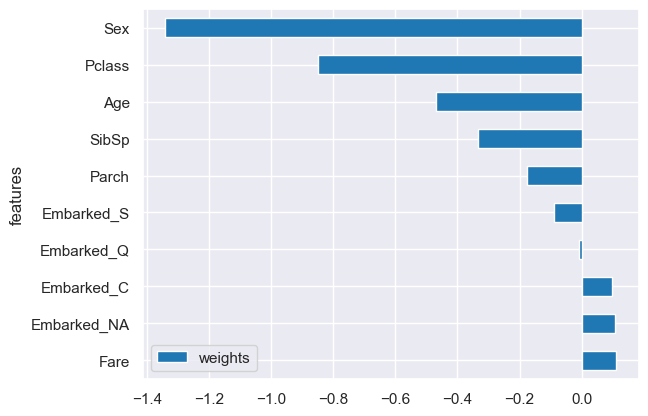

In [176]:
df = pd.DataFrame({'features': features, 'weights': weights})
df.plot.barh(x='features', y='weights')

Предсказание вероятности принадлежности к классу выживших:

In [177]:
pred_prob = expit(X_test @ clf.coef_.T + clf.intercept_)
np.allclose(pred_prob.squeeze(), clf.predict_proba(X_test)[:,1])

True

In [178]:
y_test.value_counts()

0    139
1     84
Name: Survived, dtype: int64

In [179]:
np.unique(clf.predict(X_test), return_counts=True)

(array([0, 1], dtype=int64), array([142,  81], dtype=int64))

In [180]:
accuracy_score = metrics.accuracy_score(y_test, clf.predict(X_test))
accuracy_score

0.7982062780269058

In [181]:
accuracy_score == np.equal(y_test, clf.predict(X_test)).mean()

True

***
## <a id='toc1_10_'></a>[__UCI Spambase__](#toc0_)

__https://archive.ics.uci.edu/ml/datasets/spambase__

Attribute Information:

The last column of 'spambase.data' denotes whether the e-mail was considered spam (1) or not (0), i.e. unsolicited commercial e-mail. Most of the attributes indicate whether a particular word or character was frequently occuring in the e-mail. The run-length attributes (55-57) measure the length of sequences of consecutive capital letters. For the statistical measures of each attribute, see the end of this file. Here are the definitions of the attributes:

48 continuous real [0,100] attributes of type word_freq_WORD
= percentage of words in the e-mail that match WORD, i.e. 100 * (number of times the WORD appears in the e-mail) / total number of words in e-mail. A "word" in this case is any string of alphanumeric characters bounded by non-alphanumeric characters or end-of-string.

6 continuous real [0,100] attributes of type char_freq_CHAR]
= percentage of characters in the e-mail that match CHAR, i.e. 100 * (number of CHAR occurences) / total characters in e-mail

1 continuous real [1,...] attribute of type capital_run_length_average
= average length of uninterrupted sequences of capital letters

1 continuous integer [1,...] attribute of type capital_run_length_longest
= length of longest uninterrupted sequence of capital letters

1 continuous integer [1,...] attribute of type capital_run_length_total
= sum of length of uninterrupted sequences of capital letters
= total number of capital letters in the e-mail

1 nominal {0,1} class attribute of type spam
= denotes whether the e-mail was considered spam (1) or not (0), i.e. unsolicited commercial e-mail.

In [182]:
SPAMBASE_NAMES_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.names'
SPAMBASE_DATA_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data'

features_raw = urllib.request.urlopen(SPAMBASE_NAMES_URL).readlines()[33:]
features = [line.decode().split(':')[0] for line in features_raw]
features.append('spam')

data = pd.read_csv(SPAMBASE_DATA_URL, header=None, names=features) 
X, y = data.iloc[:,:-1].values, data.iloc[:,-1].values 
data.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [183]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
logreg = LogisticRegression(max_iter=10_000).fit(X_train, y_train)
metrics.accuracy_score(y_test, logreg.predict(X_test))

0.9229098805646037

***
## <a id='toc1_11_'></a>[__Heart Disease Dataset__](#toc0_)

This data set dates from 1988 and consists of four databases: Cleveland, Hungary, Switzerland, and Long Beach V. It contains 76 attributes, including the predicted attribute, but all published experiments refer to using a subset of 14 of them. The "target" field refers to the presence of heart disease in the patient. It is integer valued 0 = no disease and 1 = disease.

Attributes:

* age
* sex
* chest pain type (4 values)
* resting blood pressure
* serum cholestoral in mg/dl
* fasting blood sugar > 120 mg/dl
* resting electrocardiographic results (values 0,1,2)
* maximum heart rate achieved
* exercise induced angina
* oldpeak = ST depression induced by exercise relative to rest
* the slope of the peak exercise ST segment
* number of major vessels (0-3) colored by flourosopy
* thal: 0 = normal; 1 = fixed defect; 2 = reversable defect

The names and social security numbers of the patients were removed from the database, replaced with dummy values.

In [222]:
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [223]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [224]:
df.target.mean()

0.5445544554455446

In [225]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns='target'), df.target,
    test_size=0.25, random_state=13
)

[__sklearn.linear_model.SGDClassifier__](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn-linear-model-sgdclassifier)

In [226]:
clf_no_regul = SGDClassifier(
    loss='log_loss', 
    alpha=0,  # параметр регуляризации (коэфф. перед регуляризатором)
    learning_rate='constant', eta0=0.1,
    random_state=13
)

In [227]:
clf_L1 = SGDClassifier(
    loss='log_loss', 
    penalty='l1', alpha=0.1,
    learning_rate='optimal',
    random_state=13
)

In [235]:
for clf in clf_no_regul, clf_L1:
    clf.fit(X_train, y_train)
    
    params = clf.get_params()
    penalty, alpha = params['penalty'], params['alpha']
    print(f'{penalty=}, {alpha=}')
    
    accuracy_score = metrics.accuracy_score(y_test, clf.predict(X_test))
    print('Accuracy score:', accuracy_score)
    
    roc_auc_score = metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
    print('ROC-AUC score:', roc_auc_score)
    
    print('Zero/shrinked coeffs:', not np.all(clf.coef_))
    print('Coeffs L2-norm:', np.linalg.norm(clf.coef_))
    
    i = np.abs(clf.coef_).argmax()    
    print('Most important predictor:', df.columns[i], '\n')
    

penalty='l2', alpha=0
Accuracy score: 0.618421052631579
ROC-AUC score: 0.5697674418604651
Zero/shrinked coeffs: False
Coeffs L2-norm: 175.67735435821564
Most important predictor: thalach 

penalty='l1', alpha=0.1
Accuracy score: 0.7631578947368421
ROC-AUC score: 0.8558844256518675
Zero/shrinked coeffs: True
Coeffs L2-norm: 10.429142228977849
Most important predictor: cp 

